In [ ]:
%run forward_dynamics.ipynb

jit after {'jit': True, 'jit_options': {'flags': '-Ofast'}, 'compiler': 'shell'}
number of joints = 4
[1.91365, 1.3333, 0.992578, 3.16057, 0.0136182, -0.00232471, 0.00369053, -0.00505981]


In [2]:
controller = control(arm_ss.n_joints)
pid_control = controller.arm_position_controller()
# pid_control.save('arm_pid.casadi')

number of joints = 4


In [3]:
qx = np.array([1.91318, 1.33339, 0.99245, 1.16073])
qxdot = np.array([0.0, 0.0, 0.0, 0.0])
qref = np.array([0.5, 2.2, 2.0, 3.2])
buffer = 0
ux , errr = pid_control(qx, qxdot, qref, alpha.Kp, alpha.Ki, alpha.Kd, buffer, alpha.delta_t, alpha.u_max, alpha.u_min)
print(ux)
print(errr)

[-1.4, 0.629139, 0.518764, 0.54]
[1.41318, -0.86661, -1.00755, -2.03927]


In [4]:
# Sample data
qx = np.array([1.91318, 1.33339, 0.99245, 1.16073])
qxdot = np.array([0.0, 0.0, 0.0, 0.0])
qref = np.array([0.5, 2.2, 2.0, 3.2])

# Preallocate storage as numpy arrays for better performance
positions = np.zeros((alpha.sim_n, 4))  # Assuming qx has 4 elements
velocities = np.zeros((alpha.sim_n, 4))  # Assuming qxdot has 4 elements
inputs = np.zeros((alpha.sim_n, 6))  # Size based on ux dimensions
buffer = 0
# Main loop
for i in range(alpha.sim_n):

    ux , errr = pid_control(qx, qxdot, qref, alpha.Kp, alpha.Ki, alpha.Kd, buffer, alpha.delta_t, alpha.u_max, alpha.u_min)

    a , u_used = F_next_(cs.vertcat(qx, qxdot), ux, alpha.sim_p, alpha.delta_t, alpha.joint_min, alpha.joint_max, alpha.base_T0)
    # Store data at each iteration
    positions[i, :] = qx
    velocities[i, :] = qxdot
    inputs[i, :] = np.squeeze(u_used.full())

    qx = a[0:4].full()
    qxdot = a[4:8].full()

    # Extract position and velocity and remove any extra dimensions
    qx = np.squeeze(a[0:4].full())  # Squeeze to ensure it's 1D
    qxdot = np.squeeze(a[4:8].full())  # Squeeze to ensure it's 1D

# Convert lists to numpy arrays for plotting
positions = np.array(positions).squeeze()
velocities = np.array(velocities).squeeze()
inputs = np.array(inputs).squeeze()

# Time array for plotting
time = np.arange(alpha.sim_n) * alpha.delta_t

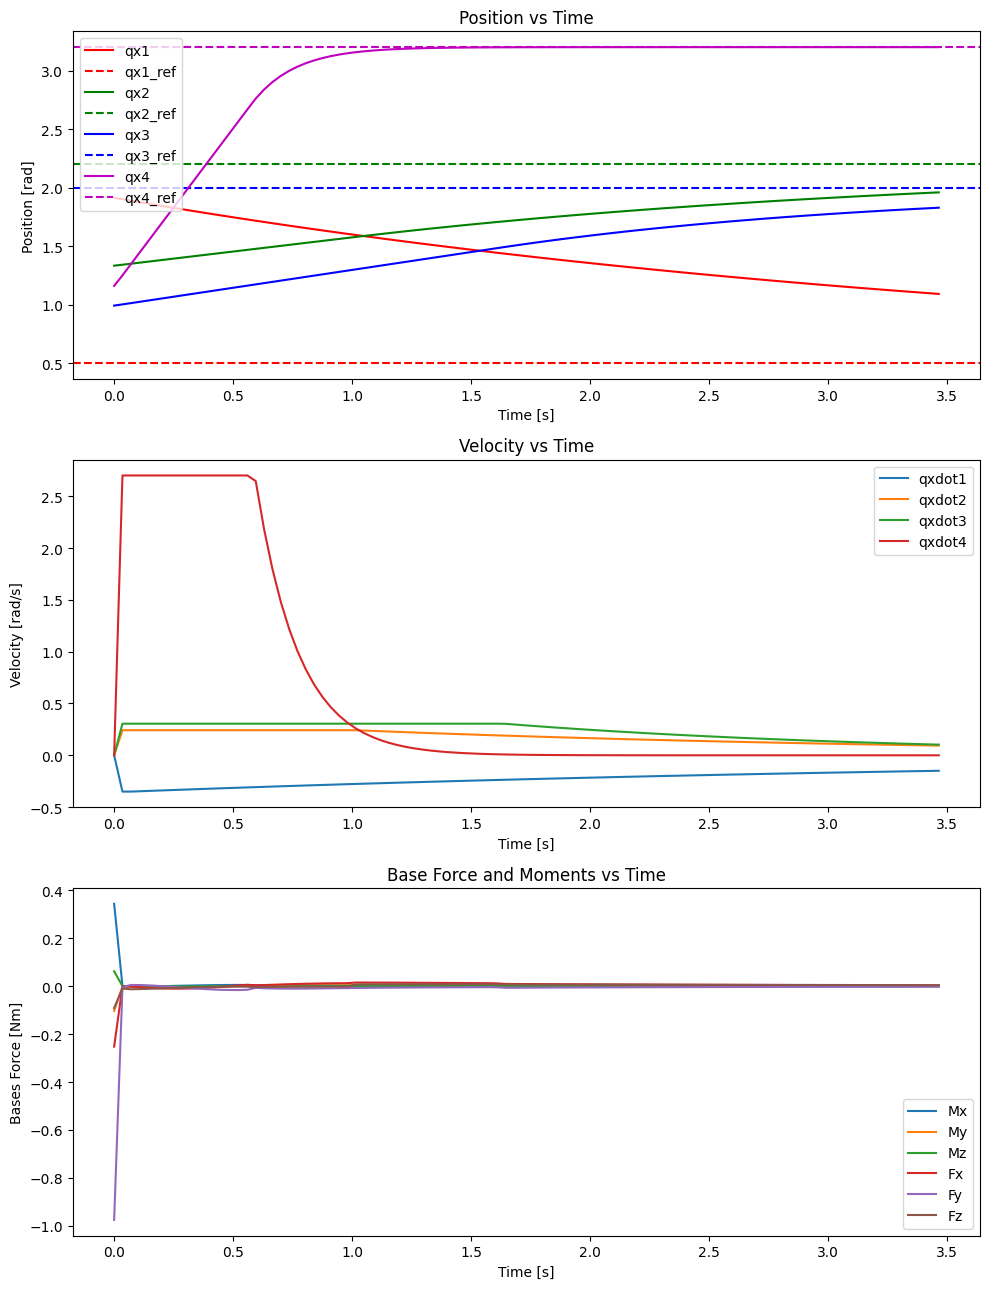

In [5]:
# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 13))

# Position plot
axs[0].plot(time, positions[:, 0], color='r', label=f'qx{1}')
axs[0].axhline(y=qref[0], color='r', linestyle='--')

axs[0].plot(time, positions[:, 1], color='g', label=f'qx{2}')
axs[0].axhline(y=qref[1], color='g', linestyle='--')

axs[0].plot(time, positions[:, 2], color='b', label=f'qx{3}')
axs[0].axhline(y=qref[2], color='b', linestyle='--')

axs[0].plot(time, positions[:, 3], color='m', label=f'qx{4}')
axs[0].axhline(y=qref[3], color='m', linestyle='--')

axs[0].set_title('Position vs Time')
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Position [rad]')
axs[0].legend(['qx1', 'qx1_ref', 'qx2', 'qx2_ref', 'qx3', 'qx3_ref', 'qx4', 'qx4_ref'])

# Velocity plot
axs[1].plot(time, velocities)
axs[1].set_title('Velocity vs Time')
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Velocity [rad/s]')
axs[1].legend(['qxdot1', 'qxdot2', 'qxdot3', 'qxdot4'])

# Input plot
axs[2].plot(time, inputs)
axs[2].set_title('Base Force and Moments vs Time')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Bases Force [Nm]')
axs[2].legend(['Mx', 'My', 'Mz', 'Fx', 'Fy', 'Fz'])

plt.tight_layout()
plt.show()
